We think one person's viral shedding in wastewater over time can be modeled as a beta/gamma function (scaled and widened to 30 days).

We assume it takes tau days for someone to have a positive test reported. So, clinical case counts are tau days behind what we observe in wastewater.

We are using clinical case data from 3/1-5/20 from 3 counties (Norfolk, Suffolk, Middlesex) downloaded from mass.gov

We want to do the model fitting for AD alone, AB alone, and the nonscaled average of AD + AB data. We expect it to give similar results.

Fuqing's correlation analysis shows correlation is best with time lag 4 days.

Define:
- S(t) : to fit : viral shedding in wastewater since time of contact
    - We assume S(t) is a beta function with parameters a, b, scaling factor c
- R(t) : known : number of reported NEW clinical cases per day
- I(t) : calculate from R(t) : number of NEW clinical cases per day (I(t) = R(t+tau), clinical cases reported on April 5 actually appeared on April 1)
- W(t) : observed : viral concentration observed in wastewater at Deer Island * flow rate [total viral load]
    - W(t) = S(t) o I(t)

Need to:
0. calculate R(t) from clinical data : take the delta between days in the cumulative case counts in 3 DI counties (from Eric)
1. calculate I(t) from R(t) : shift in time by tau days
2. Write a function to optimize a, b, c of beta function to minimize SSE between S(t) o I(t) and W(t)
3. iterate through values of tau and record score fxn and params of optimal beta

I will use Metropolis-Hastings MCMC to get confidence intervals.
To account for asymptomatic cases, I will add in an asymptomatic factor. CDC shows 6x-24x more people have positive serology compared to reported cases. https://jamanetwork.com/journals/jamainternalmedicine/fullarticle/2768834

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.optimize import minimize
from scipy.stats import beta
from scipy.stats import gamma
from scipy.stats import pearsonr
from scipy.stats import spearmanr

In [2]:
conversion_factor = 3.785411784e+9 # 1 MGD = 3.785412e9 ml
ww_volume = 1.36e12 #ml

In [3]:
# return the gamma pdf
def test_gamma(params):
    a, b, c = params
    quantile = np.linspace(0,29,30)
    G = c * gamma.pdf(quantile, a=a, scale=b)
    
    return G

In [4]:
# produce the beta pdf
def test_pdf(params):
    a, b, c, = params
    # PDF
    quantile = np.arange(0.0, 1, 1/30)
    B = c * beta.pdf(quantile, a, b) 
    return B

In [5]:
# compute the convolution between infected people I(t) and the shedding function S(t)
def convolve_I_S(params, I, function):
    if function == 'beta':
        S = test_pdf(params)
    elif function == 'gamma':
        S = test_gamma(params)
    W = np.convolve(S, I)
    return W

In [6]:
# shift clinical date time by tau days
def shift_clinical(clin, tau, factor):
    shifted_clinical = clin.copy()
    shifted_clinical['Date'] = shifted_clinical['Date'] - np.timedelta64(int(tau), 'D')
    
    # Apply asymptomatic correction
    shifted_clinical['Corrected_cases'] = shifted_clinical.New_cases * int(factor)

    return shifted_clinical

In [7]:
# minimize the SSE between the observed wastewater data and the model I * S
# reference: http://adventuresinpython.blogspot.com/2012/08/fitting-differential-equation-system-to.html
def optimize_fit_2(ww_data, cases, a, b, c, plot, function):
    
    # get real wastewater data:
    W_obs = ww_data.copy()

    # get clinical data
    I_t = cases['Date']
    I = cases['Corrected_cases']

    # set up model params of wastewater data W_model = S o I
    params = (a, b, c)

    # get model output and merge with observations
    def evaluate_model(parameters):
        W_model = np.log10(convolve_I_S(parameters, I, function))
        Wm_series = pd.Series(W_model).rename('Log_convolution')
        Wm_df = pd.concat([I_t, Wm_series], axis=1).dropna()
        Wm_merged = Wm_df.merge(W_obs, on=['Date'])

        return Wm_df, Wm_merged
    
    # define the score fxn (SSE)
    def score(parms):
        # get model output and merge with observations
        Wm_df, Wm_merged = evaluate_model(parms)

        # sum of squared error
        ss=lambda data,model:((data-model)**2).sum()
        return ss(Wm_merged['log'], Wm_merged['Log_convolution'])

    fit_score=score(params)

    # evaluate model
    Wm_df, Wm_merged = evaluate_model(params)


    # plot the observed and model wastewater data on a log scale
    def plot_fancy_fit(Wm_df, Wm_merged, my_score, parameters):
        a, b, c = parameters
        plt.figure()
        plt.plot_date(Wm_df['Date'], Wm_df['Log_convolution'])
        plt.plot_date(Wm_merged['Date'], Wm_merged['log'])
        plt.legend(['Model Points','Observed Data Points'])
        plt.xticks(rotation=90)
        plt.ylabel('log(SARS-CoV-2 RNA concentration)')
        title = ('S(t) * I(t)   SSE: '+str(round(my_score,3))
                 + '\n a=' + str(round(a,3)) + ' , b=' + str(round(b,3)) + ' , c=' + str(round(c,3)))
        plt.title(title)
        return

#     if plot:
#         plot_fancy_fit(Wm_df, Wm_merged, fit_score, params)
        
        
    # optimize fit using L-BFGS method
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fmin_l_bfgs_b.html#scipy.optimize.fmin_l_bfgs_b
    ftol = np.finfo(float).eps * 1e7 # for moderate accuracy
    answ = minimize(score, (params), method='L-BFGS-B', tol=ftol,
                    bounds = ((1e-12, None), (1e-12, None), (1e-12, None)),
                    options={'disp' : True})
    best_score = answ.fun
    ao, bo, co = answ.x
    newrates = (ao, bo, co)

    # evaluate the model with the optimized parameters
    Wm_df, Wm_merged = evaluate_model(newrates)
    
    # plot optimized system
    if plot:
        plot_fancy_fit(Wm_df, Wm_merged, best_score, newrates)
    
        # plot the inferred beta function
        plt.figure()
        if function=='beta':
            B = test_pdf(newrates)
        elif function=='gamma':
            B = test_gamma(newrates)
        plt.scatter(range(len(B)), B)
        plt.title('a=' + str(round(ao,2)) + '  b=' + str(round(bo,2)) + '  c=' + str(round(co,4)))
    
    return newrates, best_score, Wm_df, Wm_merged


In [8]:
# MCMC for confidence intervals
# reference: https://towardsdatascience.com/from-scratch-bayesian-inference-markov-chain-monte-carlo-and-metropolis-hastings-in-python-ef21a29e25a

# define the transition models for each variable of the shedding model (a, b, c)
transition_model = lambda x: np.random.normal(x, [1, 1, 0.001], (3,))

def prior(x):
    # return 1 for valid values (a,b,c > 0)
    # return 0 for invalid values (a,b, or c <= 0)
    if (x[0] <= 0 or x[1] <= 0 or x[2] <= 0):
        return 0
    else:
        return 1

def log_lik(x, ww_data, cases, function):

    # get real wastewater data:
    W_obs = ww_data.copy()
    n = len(W_obs.dropna())

    # get clinical data
    I_t = cases['Date']
    I = cases['Corrected_cases']

    # set up model params of wastewater data W_model = S o I
    params = (x[0], x[1], x[2])    
    
    # get c * beta(a,b) and convolve with new cases per day
    y_hat = convolve_I_S(params, I, function)
    Y_hat = np.log10(y_hat) # take the log
    
    # transform it into a series and merge with observed data based on date
    Y_hat_series = pd.Series(Y_hat).rename('Log_convolution')
    Y_df = pd.concat([I_t, Y_hat_series], axis=1).dropna()
    Y_merged = Y_df.merge(W_obs, on=['Date'])
    
    # SSE
    SSE = np.sum((Y_merged['log'] - Y_merged['Log_convolution'])**2)
    
    # log likelihood = (n/2)*ln(1/(2pi*sigma**2)) - (1/(2sigma**2))*SSE
    ll = (n/2)*np.log(1/(2*np.pi*SIGMA**2)) - 1/(2*SIGMA**2)*SSE

    return ll

# p(accept) = 1 if ll_new + prior_new > ll_old + prior_old
# p(accept) = exp((ll_new + prior_new) - (ll_old + prior_old))
def accept(ll, ll_new):
    T = 5
    if ll_new > ll:
        return True
    else:
        accept = np.random.uniform(0,1)
        return (accept < (np.exp((ll_new - ll)/2)))

def metropolis_hastings(likelihood_computer, prior, transition_model,
                       param_init, iterations, ww_data, I, function, accept):
    # likelihood_computer(x,data): returns the likelihood that these params generated this data
    # transition_model(x): draws a sample from a symmetric distribution and returns it
    # param_init: a starting parameter set
    # iterations: number of iterations to run
    # ww_data: the wastewater data we are modeling
    # I: clinical data we are using to model
    # function: beta or gamma for shedding
    # accept(x, x_new): decides whether to accept or reject the new params
    
    p = param_init
    accepted = []
    rejected = []
    
    for i in range(iterations):
        p_new = transition_model(p)
        ll = likelihood_computer(p, ww_data, I, function)
        ll_new = likelihood_computer(p_new, ww_data, I, function)
        if (accept(ll+np.log(prior(p)), ll_new+np.log(prior(p_new)))):
            p = p_new
            accepted.append(p_new)
        else:
            rejected.append(p_new)
    
    return np.array(accepted), np.array(rejected)

In [9]:
def fill_dates(data):
    # fill in missing days
    idx = pd.date_range(data.Date.min(), data.Date.max())
    data.index = pd.DatetimeIndex(data.Date)
    data = data.reindex(idx)
    data.Date = data.index
    data = data.reset_index(drop=True)
    
    return data

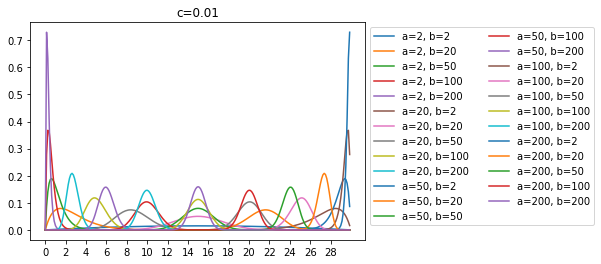

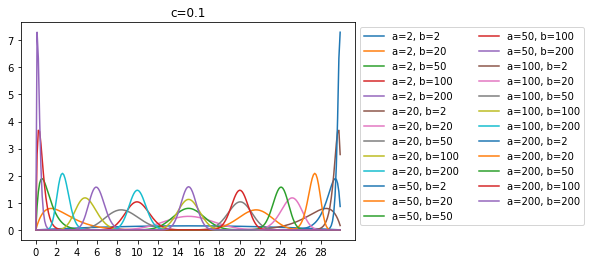

In [10]:
# plot all the betas we are starting with
a_list = [2, 20, 50, 100, 200]
b_list = [2, 20, 50, 100, 200]
c_list = [1/100, 1/10]

for c in c_list:
    plt.figure()

    for a in a_list:
        for b in b_list:
            samples = np.arange(0.0, 1, 1/30/8)
            B = c * beta.pdf(samples, a, b) 
            label = 'a=' + str(a) + ', b=' + str(b)
            plt.plot(samples, B, label=label)
    plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=2)
    plt.xticks(samples[::16], np.arange(0,31,2))
    plt.title("c=" + str(c))

In [11]:
# read in average AB/AD data
# import data
ave = pd.read_csv('../data/deer_island/split_paper/2021-06-07_Summary.ABAD_Onestep.6_DNAstandard_nonscaled_average.csv', parse_dates=[0])
AB_alone = pd.read_csv('../data/deer_island/split_paper/2021-06-07_Summary.ABAD_Onestep.6_DNAstandard_AB_alone.csv', parse_dates=[2])
AD_alone = pd.read_csv('../data/deer_island/split_paper/2021-06-07_Summary.ABAD_Onestep.6_DNAstandard_AD_alone.csv', parse_dates=[2])

# fill in missing dates
ave = fill_dates(ave)
AB_alone = fill_dates(AB_alone)
AD_alone = fill_dates(AD_alone)

# Read in clinical case counts for Deer Island counties
clinical = pd.read_csv('../data/deer_island/20200520_DI_counties_Middlesex_clinical_counts_FQW.csv',
                      parse_dates=[0])

# change to logs
clinical['log_new_cases'] = np.log10(clinical['New_cases'])
clinical.loc[~np.isfinite(clinical.log_new_cases), 'log_new_cases'] = 0.0

AB_alone['log'] = np.log10(AB_alone['Adjusted.Copyperml'])
AD_alone['log'] = np.log10(AD_alone['Adjusted.Copyperml'])
ave['log'] = np.log10(ave['Adjusted.Copyperml'])

C:\Users\harum\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log10


In [12]:
# get the tidydata and calculate the standard deviation of each data point in log space
method2 = pd.read_csv('../data/deer_island/split_paper/Summary.ABAD_Onestep.timeseries.6.DNAstandard_withFlow.csv', parse_dates=[2])

# do log 10 of adjusted copies per ml
log_adjusted = (method2.loc[:,['Adjusted.Copyperml.N1rep1', 'Adjusted.Copyperml.N1rep2',
              'Adjusted.Copyperml.N2rep1', 'Adjusted.Copyperml.N2rep2']]).apply(np.log10)
# calculate std dev for each sample and take the average of all samples
SIGMA = np.mean(log_adjusted.apply(np.std, axis=1))
print(SIGMA)

0.14835615486221534


## AD alone, tau=4, beta

C:\Users\harum\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log10
C:\Users\harum\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:663: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


optimized tau: 4
optimized params: (10.379535961073248, 197.00652708376086, 0.03413144574242055)


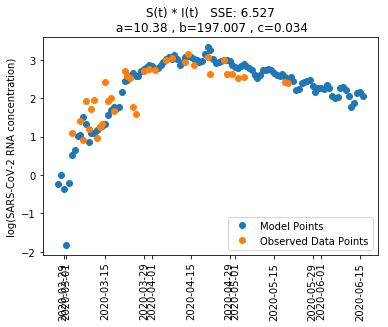

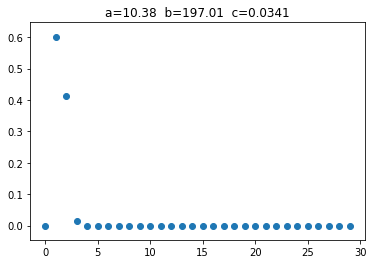

In [13]:
a_list = [2, 20, 50, 100, 200]
b_list = [2, 20, 50, 100, 200]
c_list = [0.01, 0.1]
tau_list = [4]

params_list = [] #list to hold optimal parameters tau, a, b, c
scores_list = [] #list to hold sse

for tau in tau_list:
    shifted = shift_clinical(clinical, tau, factor=1)
    for a in a_list:
        for b in b_list:
            for c in c_list:
                params,score,_,_ = optimize_fit_2(ww_data=AD_alone, cases=shifted,
                                                  a=a, b=b, c=c, plot=False,
                                                 function='beta')
                params_list.append((tau, params))
                scores_list.append(score)

plt.close('all')
min_idx = np.argmin(scores_list)
best_score = scores_list[min_idx]
best_tau, best_abc= params_list[min_idx]
best_a, best_b, best_c = best_abc

print('optimized tau:', best_tau)
print('optimized params:', best_abc)

shifted = shift_clinical(clinical, best_tau, factor = 1)
_,_, Wm_df, Wm_merged = optimize_fit_2(ww_data=AD_alone, cases=shifted,
                                                a=best_a, b=best_b, c=best_c,
                                                plot=True, function='beta')

C:\Users\harum\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in log10


0.5503


Text(0, 0.5, 'Viral copies per day')

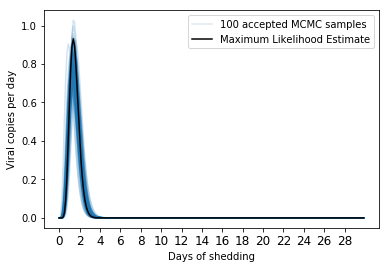

In [14]:
# metropolis hastings algorithm for confidence intervals around best_abc
best_abc = (10.379535961073248, 197.00652708376086, 0.03413144574242055)
accepted, rejected = metropolis_hastings(log_lik, prior, transition_model,
                       best_abc, 10000, AD_alone, shifted, 'beta', accept)

accepted_df = pd.DataFrame(data=accepted, columns=['a', 'b', 'c'])
rejected_df = pd.DataFrame(data=rejected, columns=['a', 'b', 'c'])

random_100 = accepted_df.sample(n=100)
random_100_reject = rejected_df.sample(n=100)

plt.figure()

# make a smoother graph by adding more datapoints than once per day
samples = np.arange(0.0, 1, 1/30/8)

for _, row in random_100.iterrows():
    test_params = row.values
    test_smooth = test_params[2] * beta.pdf(samples, test_params[0], test_params[1])
    plt.plot(samples, test_smooth, color='tab:blue', alpha=0.2)

# plot best beta
plt.plot(samples, test_smooth, color='tab:blue', alpha=0.15, label='100 accepted MCMC samples')
best_beta_smooth = best_abc[2] * beta.pdf(samples, best_abc[0], best_abc[1])
plt.plot(samples, best_beta_smooth, color='black', zorder=101, label='Maximum Likelihood Estimate')

# relabel x as day 0 to day 30
plt.xticks(samples[::16], np.arange(0,31,2), fontsize=12)

plt.legend()
plt.xlabel('Days of shedding')
plt.ylabel('Viral copies per day')

In [15]:
# write accepted and rejected MCMC params to file
accepted_df.to_csv('../data/deer_island/stoten_revision_data/beta/2021-08-04_MCMC_accepted_params_AD_alone_tau4.csv', index=False)
rejected_df.to_csv('../data/deer_island/stoten_revision_data/beta/2021-08-04_MCMC_rejected_params_AD_alone_tau4.csv', index=False)

## AD alone, tau=4, factor = 6, 24

C:\Users\harum\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log10


optimized tau: 4
optimized params: (10.507656138860836, 199.55389600168357, 0.005701021033668142)


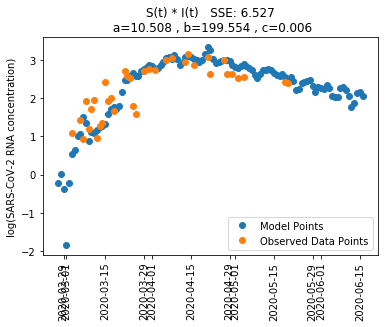

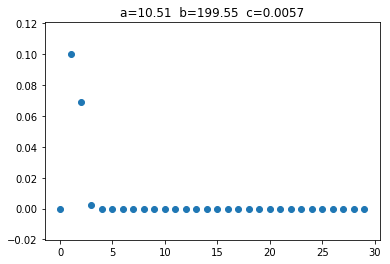

In [16]:
a_list = [2, 20, 50, 100, 200]
b_list = [2, 20, 50, 100, 200]
c_list = [0.01, 0.1]
tau_list = [4]

params_list = [] #list to hold optimal parameters tau, a, b, c
scores_list = [] #list to hold sse

for tau in tau_list:
    shifted = shift_clinical(clinical, tau, factor=6)
    for a in a_list:
        for b in b_list:
            for c in c_list:
                params,score,_,_ = optimize_fit_2(ww_data=AD_alone, cases=shifted,
                                                  a=a, b=b, c=c, plot=False,
                                                 function='beta')
                params_list.append((tau, params))
                scores_list.append(score)

plt.close('all')
min_idx = np.argmin(scores_list)
best_score = scores_list[min_idx]
best_tau, best_abc= params_list[min_idx]
best_a, best_b, best_c = best_abc

print('optimized tau:', best_tau)
print('optimized params:', best_abc)

shifted = shift_clinical(clinical, best_tau, factor = 6)
_,_, Wm_df, Wm_merged = optimize_fit_2(ww_data=AD_alone, cases=shifted,
                                                a=best_a, b=best_b, c=best_c,
                                                plot=True, function='beta')

C:\Users\harum\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in log10


Text(0, 0.5, 'Viral copies per day')

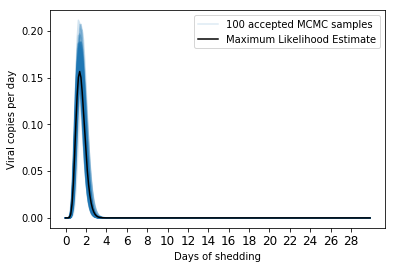

In [17]:
# metropolis hastings algorithm for confidence intervals around best_abc
best_abc = (10.507656138860836, 199.55389600168357, 0.005701021033668142)

accepted, rejected = metropolis_hastings(log_lik, prior, transition_model,
                       best_abc, 10000, AD_alone, shifted, 'beta', accept)

accepted_df = pd.DataFrame(data=accepted, columns=['a', 'b', 'c'])
rejected_df = pd.DataFrame(data=rejected, columns=['a', 'b', 'c'])

random_100 = accepted_df.sample(n=100)
random_100_reject = rejected_df.sample(n=100)

plt.figure()

# make a smoother graph by sampling more than once per day
samples = np.arange(0.0, 1, 1/30/8)

for _, row in random_100.iterrows():
    test_params = row.values
    test_smooth = test_params[2] * beta.pdf(samples, test_params[0], test_params[1])
    plt.plot(samples, test_smooth, color='tab:blue', alpha=0.2)

# plot best beta
plt.plot(samples, test_smooth, color='tab:blue', alpha=0.15, label='100 accepted MCMC samples')
best_beta_smooth = best_abc[2] * beta.pdf(samples, best_abc[0], best_abc[1])
plt.plot(samples, best_beta_smooth, color='black', zorder=101, label='Maximum Likelihood Estimate')

# relabel x as day 0 to day 30
plt.xticks(samples[::16], np.arange(0,31,2), fontsize=12)

plt.legend()
plt.xlabel('Days of shedding')
plt.ylabel('Viral copies per day')

# write accepted and rejected MCMC params to file
accepted_df.to_csv('../data/deer_island/stoten_revision_data/beta/2021-08-04_MCMC_accepted_params_AD_alone_tau4_6x_cases.csv', index=False)
rejected_df.to_csv('../data/deer_island/stoten_revision_data/beta/2021-08-04_MCMC_rejected_params_AD_alone_tau4_6x_cases.csv', index=False)

C:\Users\harum\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log10


optimized tau: 4
optimized params: (10.439633497344587, 198.20188031536335, 0.0014235853181817303)


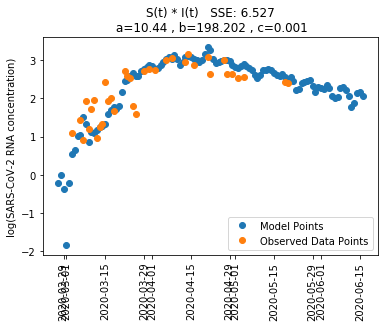

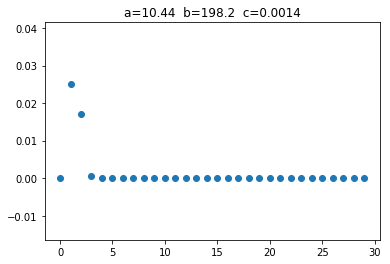

In [18]:
a_list = [2, 20, 50, 100, 200]
b_list = [2, 20, 50, 100, 200]
c_list = [0.01, 0.1]
tau_list = [4]

params_list = [] #list to hold optimal parameters tau, a, b, c
scores_list = [] #list to hold sse

for tau in tau_list:
    shifted = shift_clinical(clinical, tau, factor=24)
    for a in a_list:
        for b in b_list:
            for c in c_list:
#                 print(a, b, c)
                params,score,_,_ = optimize_fit_2(ww_data=AD_alone, cases=shifted,
                                                  a=a, b=b, c=c, plot=False,
                                                 function='beta')
                params_list.append((tau, params))
                scores_list.append(score)

plt.close('all')
min_idx = np.argmin(scores_list)
best_score = scores_list[min_idx]
best_tau, best_abc= params_list[min_idx]
best_a, best_b, best_c = best_abc

print('optimized tau:', best_tau)
print('optimized params:', best_abc)

shifted = shift_clinical(clinical, best_tau, factor = 24)
_,_, Wm_df, Wm_merged = optimize_fit_2(ww_data=AD_alone, cases=shifted,
                                                a=best_a, b=best_b, c=best_c,
                                                plot=True, function='beta')

C:\Users\harum\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in log10
C:\Users\harum\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in log10
C:\Users\harum\Anaconda3\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: divide by zero encountered in log


Text(0, 0.5, 'Viral copies per day')

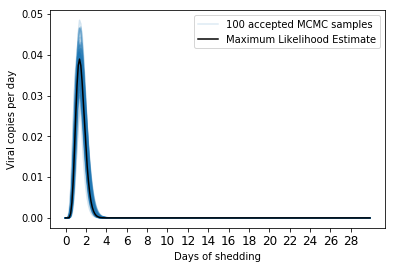

In [19]:
# metropolis hastings algorithm for confidence intervals around best_abc
best_abc = (10.439633497344587, 198.20188031536335, 0.0014235853181817303)

accepted, rejected = metropolis_hastings(log_lik, prior, transition_model,
                       best_abc, 10000, AD_alone, shifted, 'beta', accept)

accepted_df = pd.DataFrame(data=accepted, columns=['a', 'b', 'c'])
rejected_df = pd.DataFrame(data=rejected, columns=['a', 'b', 'c'])

random_100 = accepted_df.sample(n=100)
random_100_reject = rejected_df.sample(n=100)

plt.figure()

# make a smoother graph by sampling more than once per day
samples = np.arange(0.0, 1, 1/30/8)

for _, row in random_100.iterrows():
    test_params = row.values
    test_smooth = test_params[2] * beta.pdf(samples, test_params[0], test_params[1])
    plt.plot(samples, test_smooth, color='tab:blue', alpha=0.2)

# plot best beta
plt.plot(samples, test_smooth, color='tab:blue', alpha=0.15, label='100 accepted MCMC samples')
best_beta_smooth = best_abc[2] * beta.pdf(samples, best_abc[0], best_abc[1])
plt.plot(samples, best_beta_smooth, color='black', zorder=101, label='Maximum Likelihood Estimate')

# relabel x as day 0 to day 30
plt.xticks(samples[::16], np.arange(0,31,2), fontsize=12)

plt.legend()
plt.xlabel('Days of shedding')
plt.ylabel('Viral copies per day')

# write accepted and rejected MCMC params to file
accepted_df.to_csv('../data/deer_island/stoten_revision_data/beta/2021-08-04_MCMC_accepted_params_AD_alone_tau4_24x_cases.csv', index=False)
rejected_df.to_csv('../data/deer_island/stoten_revision_data/beta/2021-08-04_MCMC_rejected_params_AD_alone_tau4_24x_cases.csv', index=False)

## AD alone, tau=0-10, beta

In [20]:
a_list = [2, 20, 50, 100, 200]
b_list = [2, 20, 50, 100, 200]
c_list = [0.01, 0.1]
tau_list = np.arange(0, 11)

params_list = [] #list to hold optimal parameters tau, a, b, c
scores_list = [] #list to hold sse

for tau in tau_list:
    shifted = shift_clinical(clinical, tau, factor=1)
    for a in a_list:
        for b in b_list:
            for c in c_list:
                print(tau, a, b, c)
                params,score,_,_ = optimize_fit_2(ww_data=AD_alone, cases=shifted,
                                                  a=a, b=b, c=c, plot=False,
                                                 function='beta')
                params_list.append((tau, params))
                scores_list.append(score)

plt.close('all')
min_idx = np.argmin(scores_list)
best_score = scores_list[min_idx]
best_tau, best_abc= params_list[min_idx]
best_a, best_b, best_c = best_abc

0 2 2 0.01


C:\Users\harum\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log10


0 2 2 0.1
0 2 20 0.01
0 2 20 0.1
0 2 50 0.01
0 2 50 0.1
0 2 100 0.01
0 2 100 0.1
0 2 200 0.01
0 2 200 0.1
0 20 2 0.01
0 20 2 0.1
0 20 20 0.01
0 20 20 0.1
0 20 50 0.01
0 20 50 0.1
0 20 100 0.01
0 20 100 0.1
0 20 200 0.01
0 20 200 0.1
0 50 2 0.01
0 50 2 0.1
0 50 20 0.01
0 50 20 0.1
0 50 50 0.01
0 50 50 0.1
0 50 100 0.01
0 50 100 0.1
0 50 200 0.01
0 50 200 0.1
0 100 2 0.01
0 100 2 0.1
0 100 20 0.01
0 100 20 0.1
0 100 50 0.01
0 100 50 0.1
0 100 100 0.01
0 100 100 0.1
0 100 200 0.01
0 100 200 0.1
0 200 2 0.01
0 200 2 0.1
0 200 20 0.01
0 200 20 0.1
0 200 50 0.01
0 200 50 0.1
0 200 100 0.01
0 200 100 0.1
0 200 200 0.01
0 200 200 0.1
1 2 2 0.01
1 2 2 0.1
1 2 20 0.01
1 2 20 0.1
1 2 50 0.01
1 2 50 0.1
1 2 100 0.01
1 2 100 0.1
1 2 200 0.01
1 2 200 0.1
1 20 2 0.01
1 20 2 0.1
1 20 20 0.01
1 20 20 0.1
1 20 50 0.01
1 20 50 0.1
1 20 100 0.01
1 20 100 0.1
1 20 200 0.01
1 20 200 0.1
1 50 2 0.01
1 50 2 0.1
1 50 20 0.01
1 50 20 0.1
1 50 50 0.01
1 50 50 0.1
1 50 100 0.01
1 50 100 0.1
1 50 200 0.01
1 50 200

In [23]:
# put all the parameter sets together
params_df = pd.DataFrame(data={'params':params_list, 'scores':scores_list})

params_df[['tau', 'params']] = pd.DataFrame(params_df['params'].tolist(), index=params_df.index)

params_df[['a', 'b', 'c']] = pd.DataFrame(params_df['params'].tolist(), index=params_df.index)
params_df.to_csv('../data/deer_island/stoten_revision_data/beta/2021-08-04_tau0-10_beta_params_AD.csv', index=False)

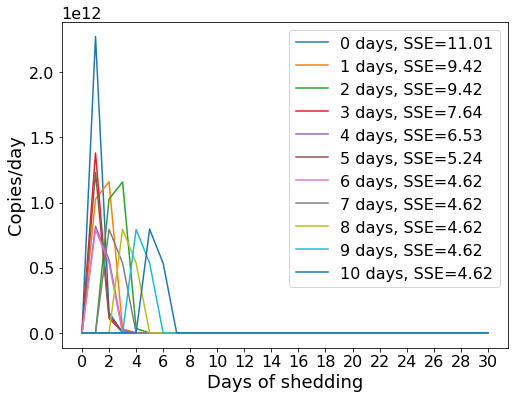

In [24]:
# look for best model for each tau
params_df = pd.read_csv('../data/deer_island/stoten_revision_data/beta/2021-08-04_tau0-10_beta_params_AD.csv')

# plot smoothly
fig, ax = plt.subplots(figsize=(8,6))
for t, tau_df in params_df.groupby(['tau']):
    if (t>=0) & (t<=10):
        best_score = tau_df.scores.min()
        best_row = tau_df.scores.idxmin()
        best_params = tau_df.loc[best_row, ['a', 'b', 'c']]
        a, b, c = best_params

        # make a smoother graph by sampling more than once per day
        samples = np.linspace(0,1,31)
        B_smooth = c * beta.pdf(samples, a, b) * ww_volume
        legend_label = str(t) + ' days, SSE=' + str(round(best_score, 2))
        plt.plot(samples, B_smooth, label = legend_label)

# plt.ylim(-0.05,2.5)
plt.legend(fontsize=16)
plt.xlabel('Days of shedding', fontsize=18)
plt.ylabel('Copies/day', fontsize=18)
plt.xticks(samples[::2], np.arange(0,31,2), fontsize=16);
plt.yticks(fontsize=16)
ax.yaxis.offsetText.set_fontsize(16)

plt.savefig('../figures/stoten_revision/2021-08-04_FigS5A_tau0-10_AD.pdf', format='pdf', dpi=300)

## AB alone, tau=4, beta

C:\Users\harum\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log10


optimized tau: 4
optimized params: (9.757025099928327, 200.89016414287826, 0.014016077280861138)


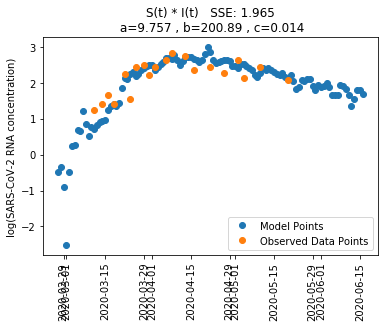

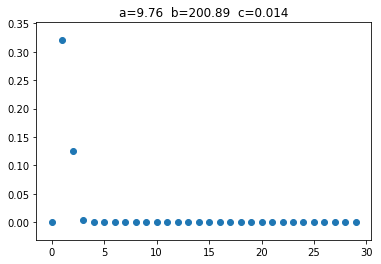

In [25]:
a_list = [2, 20, 50, 100, 200]
b_list = [2, 20, 50, 100, 200]
c_list = [0.01, 0.1]
tau_list = [4]

params_list = []
scores_list = []

for tau in tau_list:
    shifted = shift_clinical(clinical, tau, factor=1.0)
    for a in a_list:
        for b in b_list:
            for c in c_list:
#                 print(a, b, c)
                params,score,_,_ = optimize_fit_2(ww_data=AB_alone, cases=shifted,
                                                  a=a, b=b, c=c, plot=False,
                                                 function='beta')
                params_list.append((tau, params))
                scores_list.append(score)

plt.close('all')
min_idx = np.argmin(scores_list)
best_tau, best_abc = params_list[min_idx]
best_a, best_b, best_c = best_abc
print('optimized tau:', best_tau)
print('optimized params:', best_abc)

shifted = shift_clinical(clinical, best_tau, factor=1.0)
params,score, Wm_df, Wm_merged = optimize_fit_2(ww_data=AB_alone, cases=shifted,
                                                a=best_a, b=best_b, c=best_c,
                                                plot=True, function='beta')

C:\Users\harum\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in log10


0.4387


Text(0, 0.5, 'Viral copies per day')

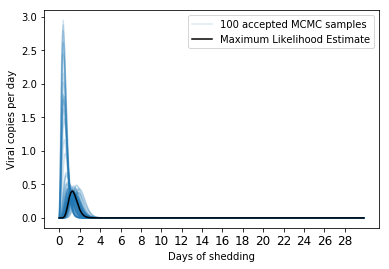

In [26]:
# metropolis hastings algorithm for confidence intervals around best_abc
best_abc = (9.757025099928327, 200.89016414287826, 0.014016077280861138)
accepted, rejected = metropolis_hastings(log_lik, prior, transition_model,
                       best_abc, 10000, AB_alone, shifted, 'beta', accept)
print(len(accepted)/10000)

accepted_df = pd.DataFrame(data=accepted, columns=['a', 'b', 'c'])
rejected_df = pd.DataFrame(data=rejected, columns=['a', 'b', 'c'])

random_100 = accepted_df.sample(n=100)
random_100_reject = rejected_df.sample(n=100)

# plot it smoothly
plt.figure()

# make a smoother graph by sampling more than once per day
samples = np.arange(0.0, 1, 1/30/8)

for _, row in random_100.iterrows():
    test_params = row.values
    test_smooth = test_params[2] * beta.pdf(samples, test_params[0], test_params[1])
    plt.plot(samples, test_smooth, color='tab:blue', alpha=0.2)

# plot best beta
plt.plot(samples, test_smooth, color='tab:blue', alpha=0.15, label='100 accepted MCMC samples')
best_beta_smooth = best_abc[2] * beta.pdf(samples, best_abc[0], best_abc[1])
plt.plot(samples, best_beta_smooth, color='black', zorder=101, label='Maximum Likelihood Estimate')

# relabel x as day 0 to day 30
plt.xticks(samples[::16], np.arange(0,31,2), fontsize=12)

plt.legend()
plt.xlabel('Days of shedding')
plt.ylabel('Viral copies per day')

In [27]:
# write accepted and rejected MCMC params to file
accepted_df.to_csv('../data/deer_island/stoten_revision_data/beta/2021-08-04_MCMC_accepted_params_AB_alone.csv', index=False)
rejected_df.to_csv('../data/deer_island/stoten_revision_data/beta/2021-08-04_MCMC_rejected_params_AB_alone.csv', index=False)

## AB alone, tau = 4, factor = 6

C:\Users\harum\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log10


optimized tau: 4
optimized params: (9.756251119254971, 200.87616534560547, 0.002335977844506277)


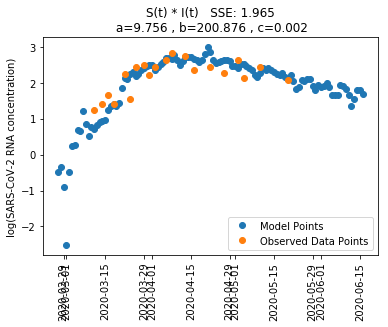

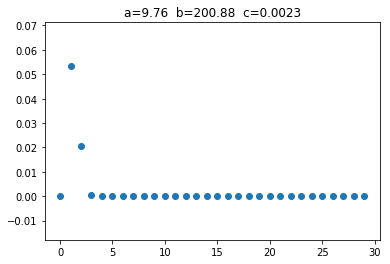

In [28]:
a_list = [2, 20, 50, 100, 200]
b_list = [2, 20, 50, 100, 200]
c_list = [0.01, 0.1]
tau_list = [4]

params_list = [] #list to hold optimal parameters tau, a, b, c
scores_list = [] #list to hold sse

for tau in tau_list:
    shifted = shift_clinical(clinical, tau, factor=6)
    for a in a_list:
        for b in b_list:
            for c in c_list:
#                 print(a, b, c)
                params,score,_,_ = optimize_fit_2(ww_data=AB_alone, cases=shifted,
                                                  a=a, b=b, c=c, plot=False,
                                                 function='beta')
                params_list.append((tau, params))
                scores_list.append(score)

plt.close('all')
min_idx = np.argmin(scores_list)
best_score = scores_list[min_idx]
best_tau, best_abc= params_list[min_idx]
best_a, best_b, best_c = best_abc

print('optimized tau:', best_tau)
print('optimized params:', best_abc)

shifted = shift_clinical(clinical, best_tau, factor=6)
params,score, Wm_df, Wm_merged = optimize_fit_2(ww_data=AB_alone, cases=shifted,
                                                a=best_a, b=best_b, c=best_c,
                                                plot=True, function='beta')

C:\Users\harum\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in log10
C:\Users\harum\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in log10
C:\Users\harum\Anaconda3\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: divide by zero encountered in log


Text(0, 0.5, 'Viral copies per day')

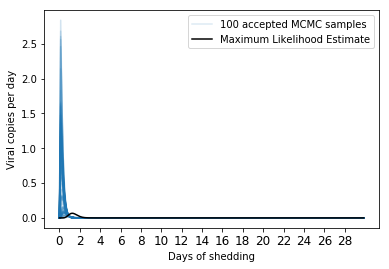

In [32]:
# metropolis hastings algorithm for confidence intervals around best_abc
best_abc = (9.756251119254971, 200.87616534560547, 0.002335977844506277)

accepted, rejected = metropolis_hastings(log_lik, prior, transition_model,
                       best_abc, 10000, AB_alone, shifted, 'beta', accept)

accepted_df = pd.DataFrame(data=accepted, columns=['a', 'b', 'c'])
rejected_df = pd.DataFrame(data=rejected, columns=['a', 'b', 'c'])

random_100 = accepted_df.sample(n=100)
random_100_reject = rejected_df.sample(n=100)

plt.figure()

# make a smoother graph by sampling more than once per day
samples = np.arange(0.0, 1, 1/30/8)

for _, row in random_100.iterrows():
    test_params = row.values
    test_smooth = test_params[2] * beta.pdf(samples, test_params[0], test_params[1])
    plt.plot(samples, test_smooth, color='tab:blue', alpha=0.2)

# plot best beta
plt.plot(samples, test_smooth, color='tab:blue', alpha=0.15, label='100 accepted MCMC samples')
best_beta_smooth = best_abc[2] * beta.pdf(samples, best_abc[0], best_abc[1])
plt.plot(samples, best_beta_smooth, color='black', zorder=101, label='Maximum Likelihood Estimate')

# relabel x as day 0 to day 30
plt.xticks(samples[::16], np.arange(0,31,2), fontsize=12)

plt.legend()
plt.xlabel('Days of shedding')
plt.ylabel('Viral copies per day')

# write accepted and rejected MCMC params to file
accepted_df.to_csv('../data/deer_island/stoten_revision_data/beta/2021-08-04_MCMC_accepted_params_AB_alone_6x_cases.csv', index=False)
rejected_df.to_csv('../data/deer_island/stoten_revision_data/beta/2021-08-04_MCMC_rejected_params_AB_alone_6x_cases.csv', index=False)

## AB alone, tau = 4, factor = 24

C:\Users\harum\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log10


optimized tau: 4
optimized params: (9.778824067252943, 201.3137212098564, 0.0005841633582241804)


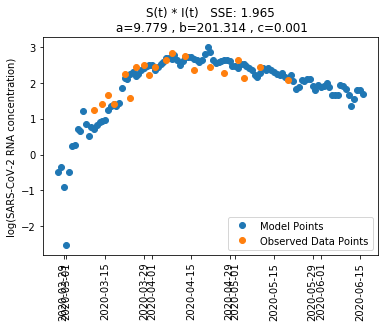

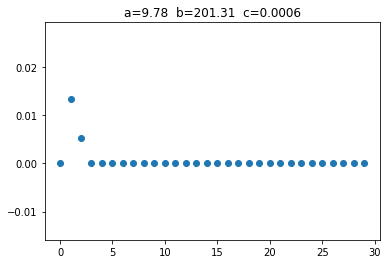

In [33]:
a_list = [2, 20, 50, 100, 200]
b_list = [2, 20, 50, 100, 200]
c_list = [0.01,0.1]
tau_list = [4]

params_list = [] #list to hold optimal parameters tau, a, b, c
scores_list = [] #list to hold sse

for tau in tau_list:
    shifted = shift_clinical(clinical, tau, factor=24)
    for a in a_list:
        for b in b_list:
            for c in c_list:
#                 print(a, b, c)
                params,score,_,_ = optimize_fit_2(ww_data=AB_alone, cases=shifted,
                                                  a=a, b=b, c=c, plot=False,
                                                 function='beta')
                params_list.append((tau, params))
                scores_list.append(score)

plt.close('all')
min_idx = np.argmin(scores_list)
best_score = scores_list[min_idx]
best_tau, best_abc= params_list[min_idx]
best_a, best_b, best_c = best_abc

print('optimized tau:', best_tau)
print('optimized params:', best_abc)

shifted = shift_clinical(clinical, best_tau, factor=24)
params,score, Wm_df, Wm_merged = optimize_fit_2(ww_data=AB_alone, cases=shifted,
                                                a=best_a, b=best_b, c=best_c,
                                                plot=True, function='beta')

C:\Users\harum\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in log10
C:\Users\harum\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in log10
C:\Users\harum\Anaconda3\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: divide by zero encountered in log


Text(0, 0.5, 'Viral copies per day')

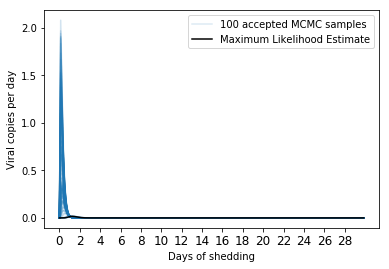

In [36]:
# metropolis hastings algorithm for confidence intervals around best_abc
best_abc = (9.778824067252943, 201.3137212098564, 0.0005841633582241804)

accepted, rejected = metropolis_hastings(log_lik, prior, transition_model,
                       best_abc, 10000, AB_alone, shifted, 'beta', accept)

accepted_df = pd.DataFrame(data=accepted, columns=['a', 'b', 'c'])
rejected_df = pd.DataFrame(data=rejected, columns=['a', 'b', 'c'])

random_100 = accepted_df.sample(n=100)
random_100_reject = rejected_df.sample(n=100)

plt.figure()

# make a smoother graph by sampling more than once per day
samples = np.arange(0.0, 1, 1/30/8)

for _, row in random_100.iterrows():
    test_params = row.values
    test_smooth = test_params[2] * beta.pdf(samples, test_params[0], test_params[1])
    plt.plot(samples, test_smooth, color='tab:blue', alpha=0.2)

# plot best beta
plt.plot(samples, test_smooth, color='tab:blue', alpha=0.15, label='100 accepted MCMC samples')
best_beta_smooth = best_abc[2] * beta.pdf(samples, best_abc[0], best_abc[1])
plt.plot(samples, best_beta_smooth, color='black', zorder=101, label='Maximum Likelihood Estimate')

# relabel x as day 0 to day 30
plt.xticks(samples[::16], np.arange(0,31,2), fontsize=12)

plt.legend()
plt.xlabel('Days of shedding')
plt.ylabel('Viral copies per day')

# write accepted and rejected MCMC params to file
accepted_df.to_csv('../data/deer_island/stoten_revision_data/beta/2021-08-04_MCMC_accepted_params_AB_alone_24x_cases.csv', index=False)
rejected_df.to_csv('../data/deer_island/stoten_revision_data/beta/2021-08-04_MCMC_rejected_params_AB_alone_24x_cases.csv', index=False)

## AB alone, tau=0-10, beta

In [37]:
a_list = [2, 20, 50, 100, 200]
b_list = [2, 20, 50, 100, 200]
c_list = [0.01, 0.1]
tau_list = np.arange(0,11)

params_list = []
scores_list = []

for tau in tau_list:
    shifted = shift_clinical(clinical, tau, factor=1)
    for a in a_list:
        for b in b_list:
            for c in c_list:
                print(a, b, c)
                params,score,_,_ = optimize_fit_2(ww_data=AB_alone, cases=shifted,
                                                  a=a, b=b, c=c, plot=False,
                                                 function='beta')
                params_list.append((tau, params))
                scores_list.append(score)

plt.close('all')
min_idx = np.argmin(scores_list)
best_tau, best_abc = params_list[min_idx]
best_a, best_b, best_c = best_abc

2 2 0.01


C:\Users\harum\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log10


2 2 0.1
2 20 0.01
2 20 0.1
2 50 0.01
2 50 0.1
2 100 0.01
2 100 0.1
2 200 0.01
2 200 0.1
20 2 0.01
20 2 0.1
20 20 0.01
20 20 0.1
20 50 0.01
20 50 0.1
20 100 0.01
20 100 0.1
20 200 0.01
20 200 0.1
50 2 0.01
50 2 0.1
50 20 0.01
50 20 0.1
50 50 0.01
50 50 0.1
50 100 0.01
50 100 0.1
50 200 0.01
50 200 0.1
100 2 0.01
100 2 0.1
100 20 0.01
100 20 0.1
100 50 0.01
100 50 0.1
100 100 0.01
100 100 0.1
100 200 0.01
100 200 0.1
200 2 0.01
200 2 0.1
200 20 0.01
200 20 0.1
200 50 0.01
200 50 0.1
200 100 0.01
200 100 0.1
200 200 0.01
200 200 0.1
2 2 0.01
2 2 0.1
2 20 0.01
2 20 0.1
2 50 0.01
2 50 0.1
2 100 0.01
2 100 0.1
2 200 0.01
2 200 0.1
20 2 0.01
20 2 0.1
20 20 0.01
20 20 0.1
20 50 0.01
20 50 0.1
20 100 0.01
20 100 0.1
20 200 0.01
20 200 0.1
50 2 0.01
50 2 0.1
50 20 0.01
50 20 0.1
50 50 0.01
50 50 0.1
50 100 0.01
50 100 0.1
50 200 0.01
50 200 0.1
100 2 0.01
100 2 0.1
100 20 0.01
100 20 0.1
100 50 0.01
100 50 0.1
100 100 0.01
100 100 0.1
100 200 0.01
100 200 0.1
200 2 0.01
200 2 0.1
200 20 0.01
200

In [38]:
# put all of the parameters together into one dataframe
params_df = pd.DataFrame(data={'params':params_list, 'scores':scores_list})

params_df[['tau', 'params']] = pd.DataFrame(params_df['params'].tolist(), index=params_df.index)
params_df[['a', 'b', 'c']] = pd.DataFrame(params_df['params'].tolist(), index=params_df.index)

# write to file
params_df.to_csv('../data/deer_island/stoten_revision_data/beta/2021-08-04_tau0-10_beta_params_AB.csv', index=False)

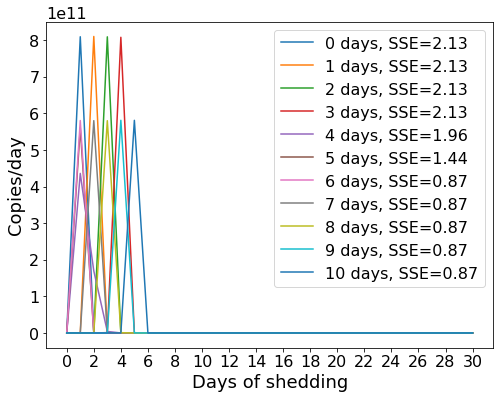

In [39]:
params_df = pd.read_csv('../data/deer_island/stoten_revision_data/beta/2021-08-04_tau0-10_beta_params_AB.csv')

# plot smoothly
fig, ax = plt.subplots(figsize=(8,6))
for t, tau_df in params_df.groupby(['tau']):
    if (t>=0) & (t<=10):
        best_score = tau_df.scores.min()
        best_row = tau_df.scores.idxmin()
        best_params = tau_df.loc[best_row, ['a', 'b', 'c']]
        a, b, c = best_params

        # make a smoother graph by sampling more than once per day
        samples = np.linspace(0,1,31)
        B_smooth = c * beta.pdf(samples, a, b) * ww_volume
        legend_label = str(t) + ' days, SSE=' + str(round(best_score, 2))
        plt.plot(samples, B_smooth, label = legend_label)

# plt.ylim(-0.05,2e12)
plt.legend(fontsize=16)
plt.xlabel('Days of shedding', fontsize=18)
plt.ylabel('Copies/day', fontsize=18)
plt.xticks(samples[::2], np.arange(0,31,2), fontsize=16);
plt.yticks(fontsize=16)
ax.yaxis.offsetText.set_fontsize(16)


plt.savefig('../figures/stoten_revision/2021-08-04_FigS5B_tau0-10_AB.pdf', format='pdf', dpi=600)

## average, tau=4, beta

C:\Users\harum\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log10


best a, b, c: (10.736122057797292, 197.61942367641294, 0.03107246888001779)
optimized tau: 4


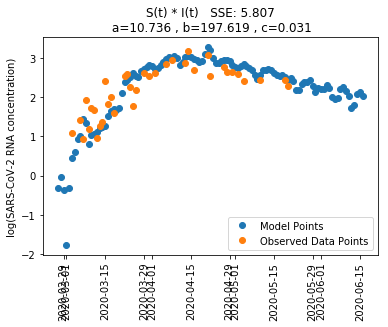

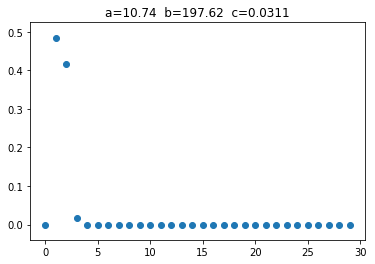

In [40]:
a_list = [2, 20, 50, 100, 200]
b_list = [2, 20, 50, 100, 200]
c_list = [0.01, 0.1]
tau_list = [4]

params_list = []
scores_list = []

for tau in tau_list:
    shifted = shift_clinical(clinical, tau, factor=1)
    for a in a_list:
        for b in b_list:
            for c in c_list:
#                 print(a, b, c)
                params,score,_,_ = optimize_fit_2(ww_data=ave, cases=shifted,
                                                  a=a, b=b, c=c, plot=False,
                                                 function='beta')
                params_list.append((tau, params))
                scores_list.append(score)

plt.close('all')
min_idx = np.argmin(scores_list)
best_tau, best_abc = params_list[min_idx]
best_a, best_b, best_c = best_abc
print('best a, b, c:', best_abc)
print('optimized tau:', best_tau)

shifted = shift_clinical(clinical, best_tau, factor=1)
params,score, Wm_df, Wm_merged = optimize_fit_2(ww_data=ave, cases=shifted,
                                                a=best_a, b=best_b, c=best_c,
                                                plot=True, function='beta')

C:\Users\harum\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in log10


Text(0, 0.5, 'Viral copies per day')

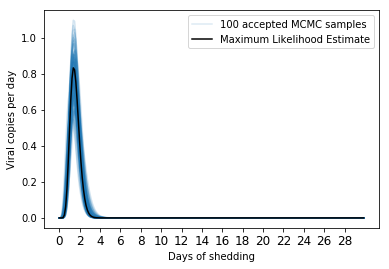

In [42]:
# metropolis hastings algorithm for confidence intervals around best_abc
best_abc = (10.736122057797292, 197.61942367641294, 0.03107246888001779)

accepted, rejected = metropolis_hastings(log_lik, prior, transition_model,
                       best_abc, 10000, ave, shifted, 'beta', accept)

accepted_df = pd.DataFrame(data=accepted, columns=['a', 'b', 'c'])
rejected_df = pd.DataFrame(data=rejected, columns=['a', 'b', 'c'])

random_100 = accepted_df.sample(n=100)
random_100_reject = rejected_df.sample(n=100)

# plot it smoothly
plt.figure()

# make a smoother graph by sampling more than once per day
samples = np.arange(0.0, 1, 1/30/8)

for _, row in random_100.iterrows():
    test_params = row.values
    test_smooth = test_params[2] * beta.pdf(samples, test_params[0], test_params[1])
    plt.plot(samples, test_smooth, color='tab:blue', alpha=0.2)

# plot best beta
plt.plot(samples, test_smooth, color='tab:blue', alpha=0.15, label='100 accepted MCMC samples')
best_beta_smooth = best_abc[2] * beta.pdf(samples, best_abc[0], best_abc[1])
plt.plot(samples, best_beta_smooth, color='black', zorder=101, label='Maximum Likelihood Estimate')

# relabel x as day 0 to day 30
plt.xticks(samples[::16], np.arange(0,31,2), fontsize=12)
plt.legend()
plt.xlabel('Days of shedding')
plt.ylabel('Viral copies per day')

# write accepted and rejected MCMC params to file
accepted_df.to_csv('../data/deer_island/stoten_revision_data/beta/2021-08-04_MCMC_accepted_params_ave.csv', index=False)
rejected_df.to_csv('../data/deer_island/stoten_revision_data/beta/2021-08-04_MCMC_rejected_params_ave.csv', index=False)

## ave, tau=4, factor = 6

C:\Users\harum\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log10


optimized tau: 4
optimized params: (10.828762193808984, 199.4800377906688, 0.00518723480248113)


C:\Users\harum\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in log10
C:\Users\harum\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in log10
C:\Users\harum\Anaconda3\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: divide by zero encountered in log


Text(0, 0.5, 'Viral copies per day')

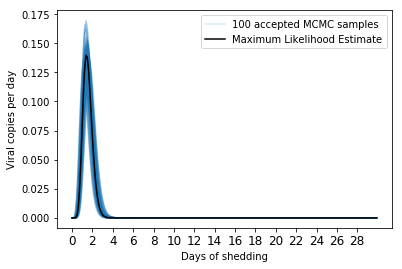

In [43]:
a_list = [2, 20, 50, 100, 200]
b_list = [2, 20, 50, 100, 200]
c_list = [0.01, 0.1]
tau_list = [4]

params_list = [] #list to hold optimal parameters tau, a, b, c
scores_list = [] #list to hold sse

for tau in tau_list:
    shifted = shift_clinical(clinical, tau, factor=6)
    for a in a_list:
        for b in b_list:
            for c in c_list:
#                 print(a, b, c)
                params,score,_,_ = optimize_fit_2(ww_data=ave, cases=shifted,
                                                  a=a, b=b, c=c, plot=False,
                                                 function='beta')
                params_list.append((tau, params))
                scores_list.append(score)

plt.close('all')
min_idx = np.argmin(scores_list)
best_score = scores_list[min_idx]
best_tau, best_abc= params_list[min_idx]
best_a, best_b, best_c = best_abc

print('optimized tau:', best_tau)
print('optimized params:', best_abc)

# metropolis hastings algorithm for confidence intervals around best_abc
accepted, rejected = metropolis_hastings(log_lik, prior, transition_model,
                       best_abc, 10000, ave, shifted, 'beta', accept)

accepted_df = pd.DataFrame(data=accepted, columns=['a', 'b', 'c'])
rejected_df = pd.DataFrame(data=rejected, columns=['a', 'b', 'c'])

random_100 = accepted_df.sample(n=100)
random_100_reject = rejected_df.sample(n=100)

plt.figure()

# make a smoother graph by sampling more than once per day
samples = np.arange(0.0, 1, 1/30/8)

for _, row in random_100.iterrows():
    test_params = row.values
    test_smooth = test_params[2] * beta.pdf(samples, test_params[0], test_params[1])
    plt.plot(samples, test_smooth, color='tab:blue', alpha=0.2)

# plot best beta
plt.plot(samples, test_smooth, color='tab:blue', alpha=0.15, label='100 accepted MCMC samples')
best_beta_smooth = best_abc[2] * beta.pdf(samples, best_abc[0], best_abc[1])
plt.plot(samples, best_beta_smooth, color='black', zorder=101, label='Maximum Likelihood Estimate')

# relabel x as day 0 to day 30
plt.xticks(samples[::16], np.arange(0,31,2), fontsize=12)

plt.legend()
plt.xlabel('Days of shedding')
plt.ylabel('Viral copies per day')

# write accepted and rejected MCMC params to file
accepted_df.to_csv('../data/deer_island/stoten_revision_data/beta/2021-08-04_MCMC_accepted_params_ave_6x_cases.csv', index=False)
rejected_df.to_csv('../data/deer_island/stoten_revision_data/beta/2021-08-04_MCMC_rejected_params_ave_6x_cases.csv', index=False)

## ave, tau=4, factor = 24

C:\Users\harum\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log10


optimized tau: 4
optimized params: (10.747687278224046, 197.8518127157473, 0.0012949462138592352)


C:\Users\harum\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in log10
C:\Users\harum\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in log10
C:\Users\harum\Anaconda3\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: divide by zero encountered in log


Text(0, 0.5, 'Viral copies per day')

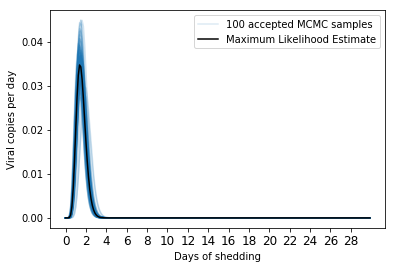

In [44]:
a_list = [2, 20, 50, 100, 200]
b_list = [2, 20, 50, 100, 200]
c_list = [0.01, 0.1]
tau_list = [4]

params_list = [] #list to hold optimal parameters tau, a, b, c
scores_list = [] #list to hold sse

for tau in tau_list:
    shifted = shift_clinical(clinical, tau, factor=24)
    for a in a_list:
        for b in b_list:
            for c in c_list:
#                 print(a, b, c)
                params,score,_,_ = optimize_fit_2(ww_data=ave, cases=shifted,
                                                  a=a, b=b, c=c, plot=False,
                                                 function='beta')
                params_list.append((tau, params))
                scores_list.append(score)

plt.close('all')
min_idx = np.argmin(scores_list)
best_score = scores_list[min_idx]
best_tau, best_abc= params_list[min_idx]
best_a, best_b, best_c = best_abc

print('optimized tau:', best_tau)
print('optimized params:', best_abc)

# metropolis hastings algorithm for confidence intervals around best_abc
accepted, rejected = metropolis_hastings(log_lik, prior, transition_model,
                       best_abc, 10000, ave, shifted, 'beta', accept)

accepted_df = pd.DataFrame(data=accepted, columns=['a', 'b', 'c'])
rejected_df = pd.DataFrame(data=rejected, columns=['a', 'b', 'c'])

random_100 = accepted_df.sample(n=100)
random_100_reject = rejected_df.sample(n=100)

plt.figure()

# make a smoother graph by sampling more than once per day
samples = np.arange(0.0, 1, 1/30/8)

for _, row in random_100.iterrows():
    test_params = row.values
    test_smooth = test_params[2] * beta.pdf(samples, test_params[0], test_params[1])
    plt.plot(samples, test_smooth, color='tab:blue', alpha=0.2)

# plot best beta
plt.plot(samples, test_smooth, color='tab:blue', alpha=0.15, label='100 accepted MCMC samples')
best_beta_smooth = best_abc[2] * beta.pdf(samples, best_abc[0], best_abc[1])
plt.plot(samples, best_beta_smooth, color='black', zorder=101, label='Maximum Likelihood Estimate')

# relabel x as day 0 to day 30
plt.xticks(samples[::16], np.arange(0,31,2), fontsize=12)

plt.legend()
plt.xlabel('Days of shedding')
plt.ylabel('Viral copies per day')

# write accepted and rejected MCMC params to file
accepted_df.to_csv('../data/deer_island/stoten_revision_data/beta/2021-08-04_MCMC_accepted_params_ave_24x_cases.csv', index=False)
rejected_df.to_csv('../data/deer_island/stoten_revision_data/beta/2021-08-04_MCMC_rejected_params_ave_24x_cases.csv', index=False)

## ave, tau=0-10, beta

In [45]:
a_list = [2, 20, 50, 100, 200]
b_list = [2, 20, 50, 100, 200]
c_list = [0.01, 0.1]
tau_list = np.arange(0,11)

params_list = []
scores_list = []

for tau in tau_list:
    shifted = shift_clinical(clinical, tau, factor=1)
    for a in a_list:
        for b in b_list:
            for c in c_list:
                print(a, b, c)
                params,score,_,_ = optimize_fit_2(ww_data=ave, cases=shifted,
                                                  a=a, b=b, c=c, plot=False,
                                                 function='beta')
                params_list.append((tau, params))
                scores_list.append(score)

plt.close('all')
min_idx = np.argmin(scores_list)
best_tau, best_abc = params_list[min_idx]
best_a, best_b, best_c = best_abc

2 2 0.01


C:\Users\harum\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log10


2 2 0.1
2 20 0.01
2 20 0.1
2 50 0.01
2 50 0.1
2 100 0.01
2 100 0.1
2 200 0.01
2 200 0.1
20 2 0.01
20 2 0.1
20 20 0.01
20 20 0.1
20 50 0.01
20 50 0.1
20 100 0.01
20 100 0.1
20 200 0.01
20 200 0.1
50 2 0.01
50 2 0.1
50 20 0.01
50 20 0.1
50 50 0.01
50 50 0.1
50 100 0.01
50 100 0.1
50 200 0.01
50 200 0.1
100 2 0.01
100 2 0.1
100 20 0.01
100 20 0.1
100 50 0.01
100 50 0.1
100 100 0.01
100 100 0.1
100 200 0.01
100 200 0.1
200 2 0.01
200 2 0.1
200 20 0.01
200 20 0.1
200 50 0.01
200 50 0.1
200 100 0.01
200 100 0.1
200 200 0.01
200 200 0.1
2 2 0.01
2 2 0.1
2 20 0.01
2 20 0.1
2 50 0.01
2 50 0.1
2 100 0.01
2 100 0.1
2 200 0.01
2 200 0.1
20 2 0.01
20 2 0.1
20 20 0.01
20 20 0.1
20 50 0.01
20 50 0.1
20 100 0.01
20 100 0.1
20 200 0.01
20 200 0.1
50 2 0.01
50 2 0.1
50 20 0.01
50 20 0.1
50 50 0.01
50 50 0.1
50 100 0.01
50 100 0.1
50 200 0.01
50 200 0.1
100 2 0.01
100 2 0.1
100 20 0.01
100 20 0.1
100 50 0.01
100 50 0.1
100 100 0.01
100 100 0.1
100 200 0.01
100 200 0.1
200 2 0.01
200 2 0.1
200 20 0.01
200

In [46]:
# put parameters together into one dataframe
params_df = pd.DataFrame(data={'params':params_list, 'scores':scores_list})
params_df[['tau', 'params']] = pd.DataFrame(params_df['params'].tolist(), index=params_df.index)
params_df[['a', 'b', 'c']] = pd.DataFrame(params_df['params'].tolist(), index=params_df.index)

# write to file
params_df.to_csv('../data/deer_island/stoten_revision_data/beta/2021-08-04_tau0-10_beta_params_ave.csv', index=False)

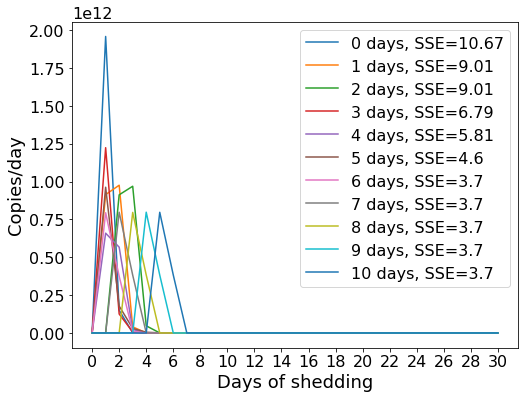

In [47]:
params_df = pd.read_csv('../data/deer_island/stoten_revision_data/beta/2021-08-04_tau0-10_beta_params_ave.csv')

# plot
fig, ax = plt.subplots(figsize=(8,6))
for t, tau_df in params_df.groupby(['tau']):
    if (t>=0) & (t<=10):
        best_score = tau_df.scores.min()
        best_row = tau_df.scores.idxmin()
        best_params = tau_df.loc[best_row, ['a', 'b', 'c']]
        a, b, c = best_params

        # plot
        samples = np.linspace(0,1,31)
        B_smooth = c * beta.pdf(samples, a, b) * ww_volume
        legend_label = str(t) + ' days, SSE=' + str(round(best_score, 2))
        plt.plot(samples, B_smooth, label = legend_label)

plt.legend(fontsize=16)
plt.xlabel('Days of shedding', fontsize=18)
plt.ylabel('Copies/day', fontsize=18)
plt.xticks(samples[::2], np.arange(0,31,2), fontsize=16);
plt.yticks(fontsize=16)
ax.yaxis.offsetText.set_fontsize(16)

# plt.savefig('../figures/stoten_revision/2021-08-04_FigS5C_tau0-10_beta_ave.pdf', format='pdf', dpi=300)
